# Classification 

## MNISET

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Generally all datasets loaded by Scikit-Learn have a similar structure, including also:
   -  A DESCR key describing the dataset
   -  A data key containing an array with one row per instance and one column per feature
   -  A targer key containing an array with the labels

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape #70000 images of 28x28 Dimension

(70000, 784)

In [7]:
y.shape #These are the labels

(70000,)

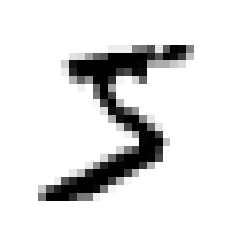

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [11]:
#Most ML algorithms expect numbers, so let's cast y to integer:

import numpy as np

y = y.astype(np.uint8)

The MNISET dataset is already split into a training set and a test set

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [13]:
y_train_5 = (y_train == 5) #True for all 5s, False all the other digits.
y_test_5 = (y_test == 5)

A good place to start with the classifier, is to pick a SGD (Stochastic Gradient Descent). This classifier has the advantage of being capable of handling very large datasets efficiently.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

#If you want reproducible results, you should set the random_state parameter

sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

A good way to evaluate the model is to use the same you did in Chapter2 

#### Implementing Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


We use the one provided by Scikit-Learn

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training).

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row represents an actual class, while each column represents a predicted class. 53892 are correctly predicted as non-5s(true negatives), while there are remaining 687 were wrongly classified as 5s(flase positives). 1891 were wrongly classified as non-5s(flase negatives), while the remaining 4096 were correctly classified as 5s(true positives). 

In [23]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Equation Precision
$$precision = \frac{True Positives}{True Positives + False Positives}$$ 

#### Equation Recall/Sensivity/TPR (True Positive Rate)
$$recall = \frac{TruePositives}{TruePositives+FalseNegatives}$$

### Precision and Recall

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

It is often convinient to combine precision and recall into a single metric called F1 score, it is the harmonic mean of precision and recall. It scores better the classifiers that have similar precision and recall.

#### Equation F1
$$F1 = \frac{TruePositives}{TruePositives + \frac{FalseNegatives + FalsePositives}{2}}$$

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7325171197343846

### Precision/Recall Trade-Off

Precision/Recall Trade-Off is when you increase the precision also reduces recall, and vice versa.

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [39]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

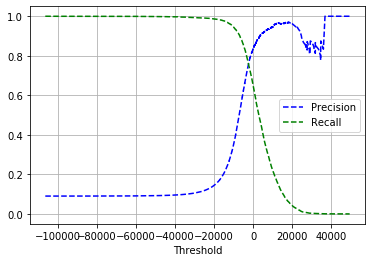

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    #Highlight the threshold
    plt.legend()
    plt.xlabel('Threshold')
    plt.grid(b=True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [58]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [59]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

Reciever Operating Characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate(Recall) against false positive rate(FPR).

$$ FPR = (1- True Negative Rate) $$

TNR is also called specificity, which is the ratio of negative instances that are correctly classified as negative.

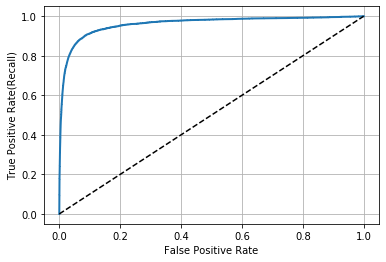

In [63]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.ylabel('True Positive Rate(Recall)')
    plt.xlabel('False Positive Rate')
    plt.grid(b=True)

plot_roc_curve(fpr,tpr)
plt.show()

One way to compare classifier is to measure the area under the curve(AUC). A perfect classifier will have a ROC AUC equal to 1.

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

You should prefer the Precision/Recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

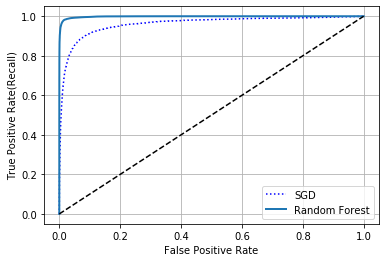

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [67]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification